## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 4 февраля 2025**

**Дедлайн: 12 февраля 2025 23:59 MSK**

In [107]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests

%matplotlib inline

## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре. 

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [108]:
df = pd.read_csv('interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [109]:
df.last_watch_dt.min()

'2021-03-13'

In [110]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
4590959,258790,4151,117,12896,25.0
5278913,681008,8727,146,464,9.0
3612903,619121,13087,126,5525,100.0
5201671,630120,3363,126,1591,26.0
4916392,1015947,7417,145,7091,100.0


Сделаем разбиение по времени

<Axes: >

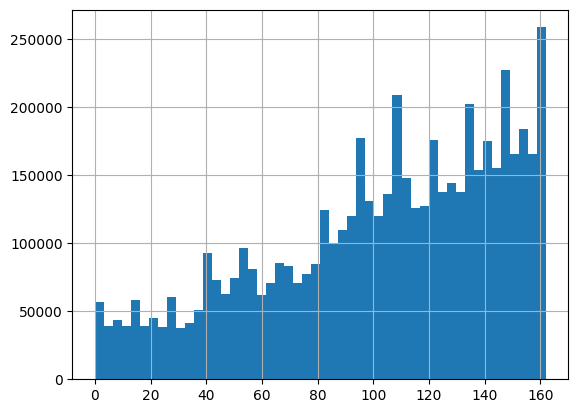

In [111]:
df.last_watch_dt.hist(bins=50)

In [112]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [113]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [114]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [115]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
11,988709,7571,116,6558,100.0
104,570761,9550,90,31738,100.0
112,490158,817,139,930,16.0
127,375013,6907,104,8079,100.0
183,339681,13865,92,6460,100.0


In [116]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

/var/folders/j7/bpk2y95s0x12x19c3ryr4v7r0000gn/T/ipykernel_1345/1105526701.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_df.groupby('user_id').apply(
/var/folders/j7/bpk2y95s0x12x19c3ryr4v7r0000gn/T/ipykernel_1345/1105526701.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = test_df.groupby('user_id').apply(


,user_id,train_interactions
0,106,"[(9335, 28), (312, 35), (11494, 35), (12965, 5..."
1,241,"[(5051, 9), (2134, 9), (13913, 112), (6646, 11..."
2,322,"[(4549, 94), (8419, 94), (14814, 94), (10219, ..."
3,400,"[(169, 144), (11047, 145), (12974, 145), (1399..."
4,446,"[(13865, 105)]"


In [117]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,106,"[(9335, 28), (312, 35), (11494, 35), (12965, 5...","[(12908, 159), (2836, 159), (12873, 159), (337..."
1,241,"[(5051, 9), (2134, 9), (13913, 112), (6646, 11...","[(6162, 156), (10440, 156), (8986, 156), (1213..."
2,322,"[(4549, 94), (8419, 94), (14814, 94), (10219, ...","[(4651, 155), (15384, 155), (11099, 157), (633..."
3,400,"[(169, 144), (11047, 145), (12974, 145), (1399...","[(7793, 153)]"
4,446,"[(13865, 105)]","[(12202, 160), (230, 160)]"


In [118]:
np.random.seed(777)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,106,"[(9335, 28), (312, 35), (11494, 35), (12965, 5...","[(12908, 159), (2836, 159), (12873, 159), (337...","[14844, 2032, 12834]"
1,241,"[(5051, 9), (2134, 9), (13913, 112), (6646, 11...","[(6162, 156), (10440, 156), (8986, 156), (1213...","[14844, 2032, 12834]"
2,322,"[(4549, 94), (8419, 94), (14814, 94), (10219, ...","[(4651, 155), (15384, 155), (11099, 157), (633...","[14844, 2032, 12834]"
3,400,"[(169, 144), (11047, 145), (12974, 145), (1399...","[(7793, 153)]","[14844, 2032, 12834]"
4,446,"[(13865, 105)]","[(12202, 160), (230, 160)]","[14844, 2032, 12834]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$. 

In [119]:
def ap_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if topn == None:
        topn = len(predictions)
    predictions = np.asarray(predictions[:topn])
    gt_set = set(gt_items)
    hits = np.isin(predictions, list(gt_set))
    _, unique_indices = np.unique(predictions, return_index=True)
    unique_hits = np.zeros_like(hits, dtype=bool)
    unique_hits[unique_indices] = hits[unique_indices]
    num_hits = np.cumsum(unique_hits)
    indices = np.arange(1, len(predictions) + 1)
    score = np.sum(num_hits[unique_hits] / indices[unique_hits])
    return score / min(len(gt_items), topn)


def rr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if topn == None:
        topn = len(gt_items)
    predictions = np.array(predictions[:topn])
    
    hits = np.isin(predictions, gt_items)
    
    if np.any(hits):
        first_hit_index = np.where(hits)[0][0] 
        return 1.0 / (first_hit_index + 1)
    else:
        return 0.0


def hr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if topn is None:
        topn = len(predictions)
    
    predictions = np.array(predictions[:topn])
    hits = np.isin(predictions, gt_items)
    return 1 if np.any(hits) else 0


Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить их, разумеется, не стоит. 

In [120]:
run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать. 

In [121]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions)
        rr = rr_metric(gt_items, predictions)
        hr = hr_metric(gt_items, predictions)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [122]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': 0.0, 'mrr': 0.0, 'hr': 0.0}

In [123]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,106,"[(9335, 28), (312, 35), (11494, 35), (12965, 5...","[(12908, 159), (2836, 159), (12873, 159), (337...","[14844, 2032, 12834]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
1,241,"[(5051, 9), (2134, 9), (13913, 112), (6646, 11...","[(6162, 156), (10440, 156), (8986, 156), (1213...","[14844, 2032, 12834]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
2,322,"[(4549, 94), (8419, 94), (14814, 94), (10219, ...","[(4651, 155), (15384, 155), (11099, 157), (633...","[14844, 2032, 12834]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
3,400,"[(169, 144), (11047, 145), (12974, 145), (1399...","[(7793, 153)]","[14844, 2032, 12834]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
4,446,"[(13865, 105)]","[(12202, 160), (230, 160)]","[14844, 2032, 12834]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания должны показать более высокое качество.

In [124]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.0672966400856639, 'mrr': 0.08590527777777777, 'hr': 0.27}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [125]:
class TopPopularWeighted(TopPopular):

    def __init__(self, min_window=2):
        super().__init__()
        self.min_window = min_window

    def fit(self, df, col='train_interactions'):
        last_date = max(max(days for _, days in row[col]) for _, row in df.iterrows())
        
        counts = {}
        for _, row in df.iterrows():
            for item, days_since_start in row[col]:
                if days_since_start >= last_date - self.min_window:
                    if item in counts:
                        counts[item] += 1
                    else:
                        counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна. 

In [126]:
def plot_metrics(results, param):

    plt.figure(figsize=(15, 6))
    plt.plot(results[param], results['map'], marker='o')
    plt.title('AP@k')
    plt.xlabel('Окно (дней)')
    plt.ylabel('AP@k')
    plt.xticks(results[param])
    plt.show()

    plt.figure(figsize=(15, 6))
    plt.plot(results[param], results['mrr'], marker='o', color='orange')
    plt.title('RR@k')
    plt.xlabel('Окно (дней)')
    plt.ylabel('RR@k')
    plt.xticks(results[param])
    plt.show()

    plt.figure(figsize=(15, 6))
    plt.plot(results[param], results['hr'], marker='o', color='green')
    plt.title('HR@k')
    plt.xlabel('Окно (дней)')
    plt.ylabel('HR@k')
    plt.xticks(results[param])
    plt.show()

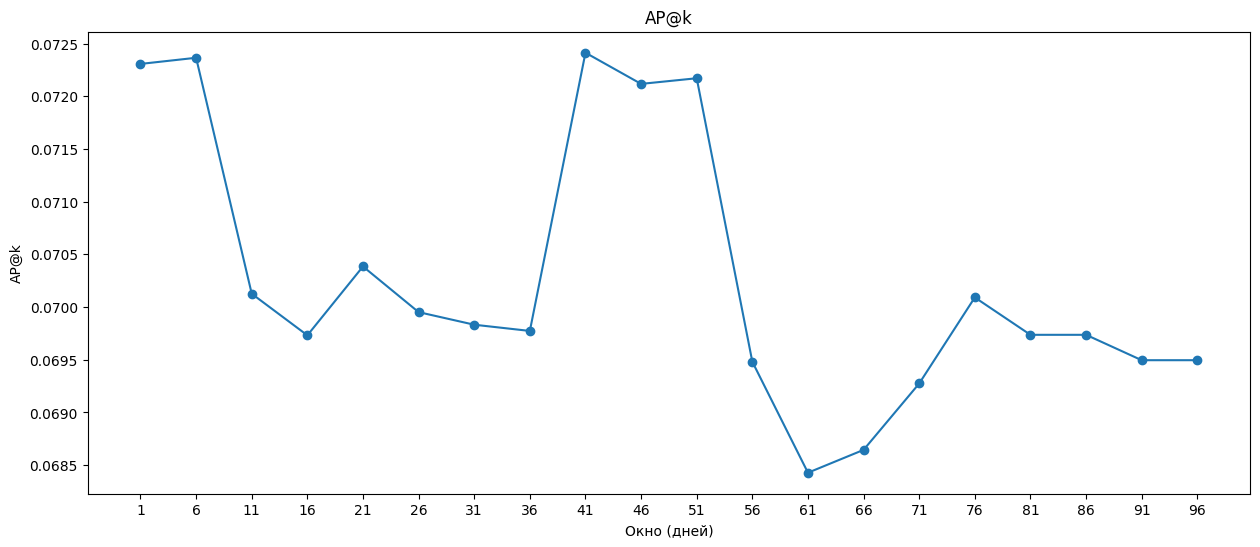

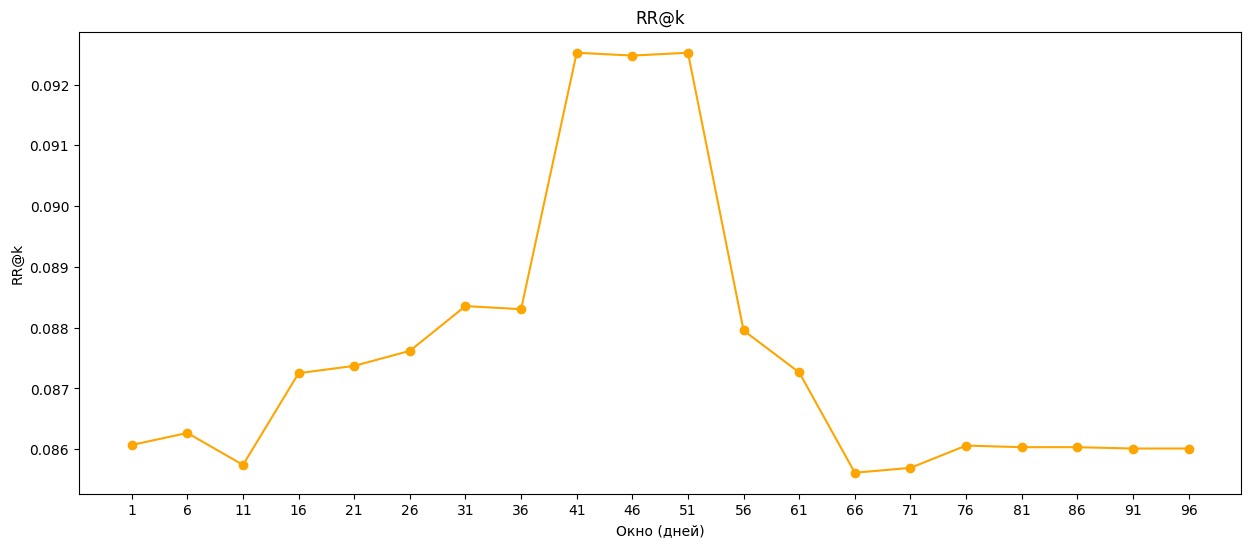

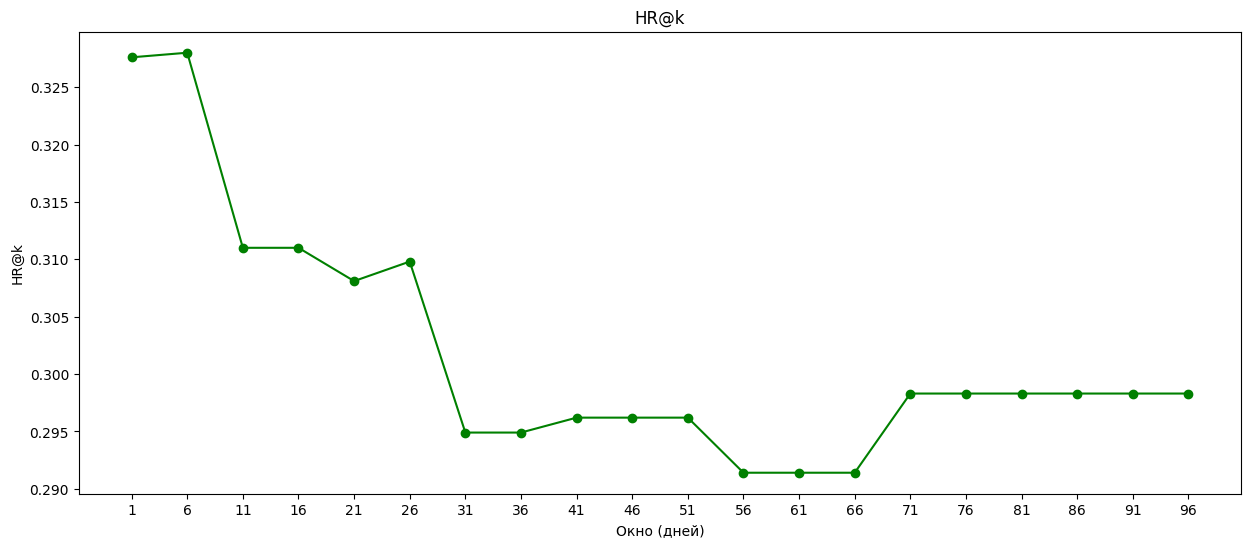

In [127]:
window_sizes = np.arange(1, 101, 5)
results = {'window_size': [], 'map': [], 'mrr': [], 'hr': []}

for window in window_sizes:
    model = TopPopularWeighted(min_window=window)

    model.fit(joined)
        
    joined['top_popular_window'] = model.predict(joined)

    metrics = evaluate_recommender(joined, model_preds='top_popular_window')
        
    results['window_size'].append(window)
    results['map'].append(metrics['map'])
    results['mrr'].append(metrics['mrr'])
    results['hr'].append(metrics['hr'])

plot_metrics(results, 'window_size')

Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:** В нашем случае увеличение размера окна до определенного предела приводит к росту метрики AP@k. Это указывает на то, что при небольшом размере окна выборки недостаточно для формирования качественных рекомендаций. В диапазоне окна от 31 до 60 метрика AP@k достигает максимума. Однако при увеличении окна свыше 61 значения AP@k начинают снижаться, что может свидетельствовать о том, что в выборку попадают устаревшие рекомендации, не отражающие изменившиеся предпочтения (например, iPhone старой версии и тп).

**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике. 

In [128]:
joined['toppopular_recs'] = toppop.predict(joined, topn=100)

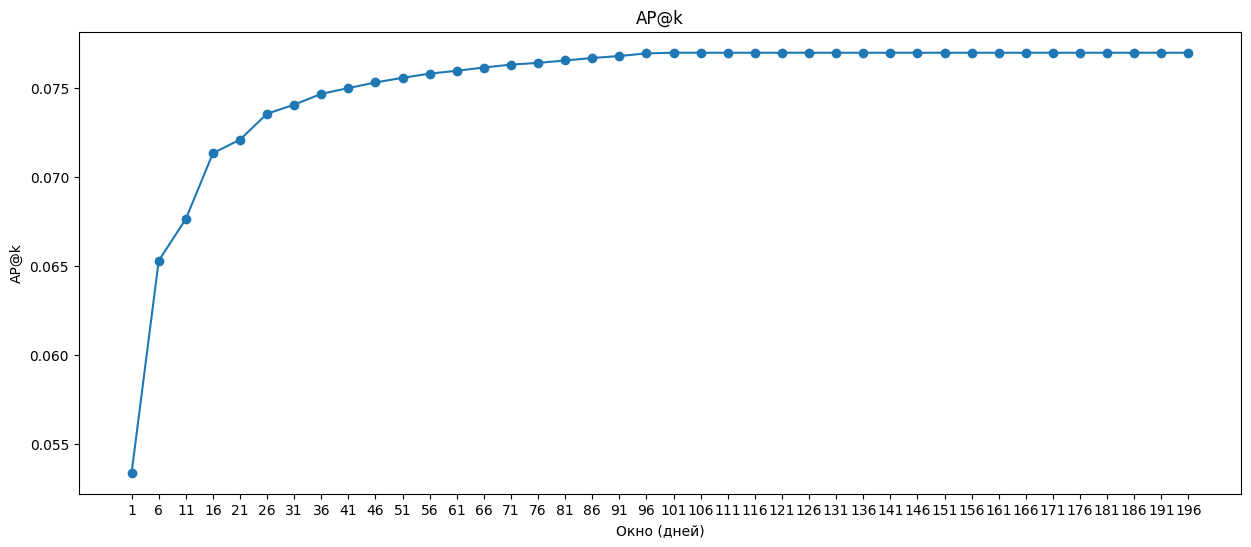

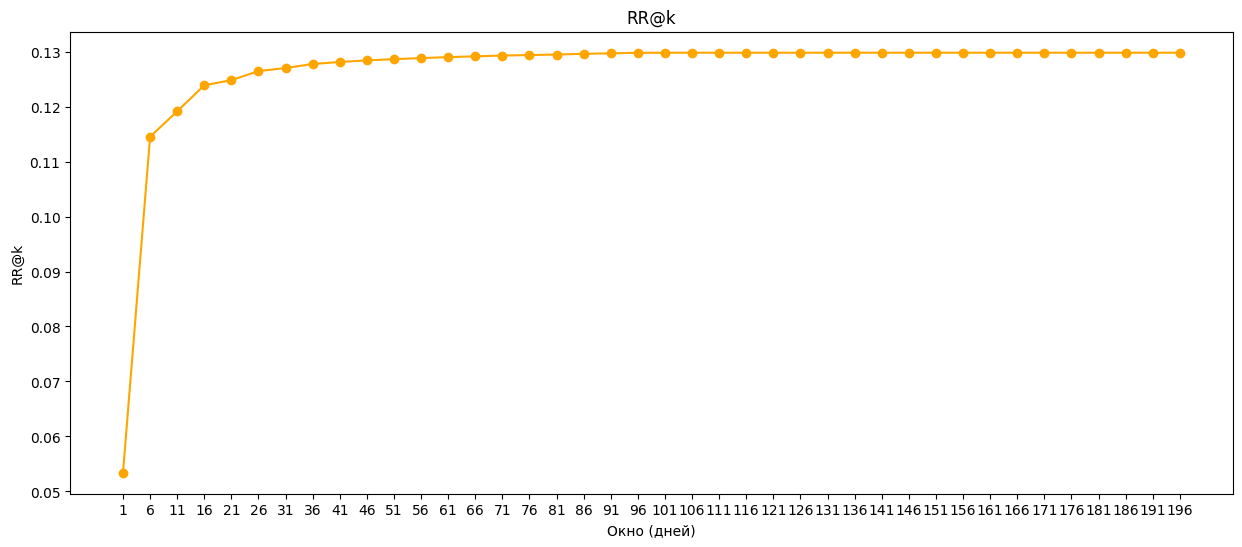

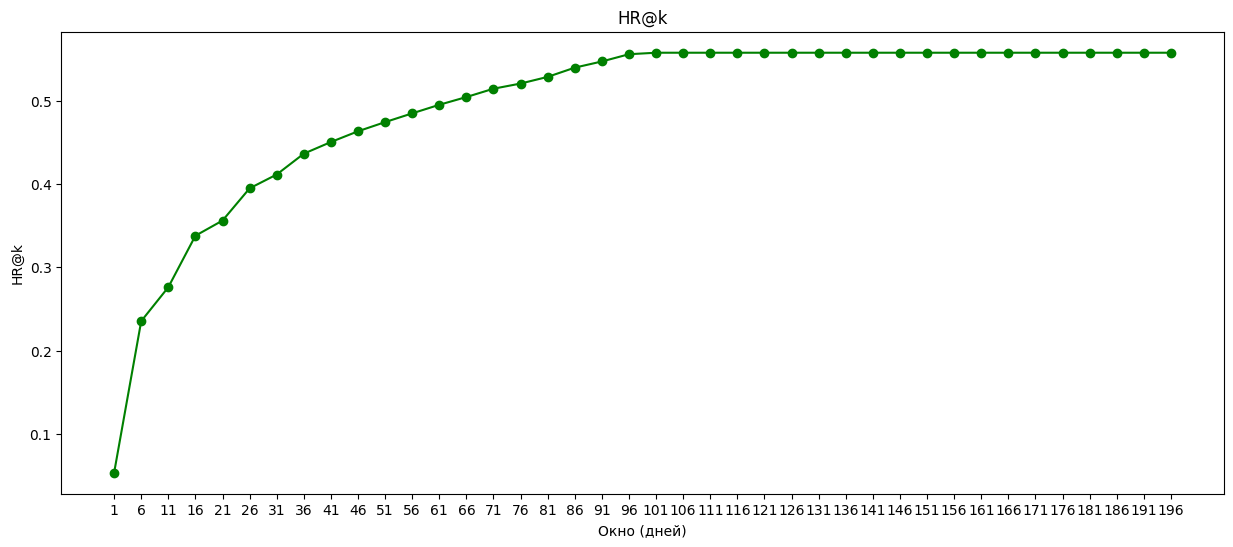

In [129]:
def evaluate_recommender_k(df, model_preds, k, gt_col='test_interactions'):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions, k)
        rr = rr_metric(gt_items, predictions, k)
        hr = hr_metric(gt_items, predictions, k)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}


results = {'k': [], 'map': [], 'mrr': [], 'hr': []}

for k in range(1, 200, 5):

    metrics = evaluate_recommender_k(joined, 'toppopular_recs', k)
    results['k'].append(k)
    results['map'].append(metrics['map'])
    results['mrr'].append(metrics['mrr'])
    results['hr'].append(metrics['hr'])

plot_metrics(results, 'k')

Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ:** 
* MAP@K - до определенного момента монотонно возрастает (по мере увеличения количества релевантных элементов в выборке). В дальнешем метрика относительно стабилизируется и колеблется около определенного уровня (поскольку последующее дополнение менее актуальных рекомендаций при росте значения k). Если система хорошо ранжирует релевантные элементы на первых позициях, то MAP@K будет расти с увеличением K, поскольку включает в себя больше релевантных элементов.
* MRR@K - на начальных этапах монотонно возрастает, поскольку растет вероятность найти первый релевантный элемент. Когда список рекомендаций становится длиннее (большие значения k), если релевантный элемент уже был найден на более ранних позициях, то дальнейшее увеличение K не существенно повлияет на метрику.
* HR@k - монотонно возрастает до определенного уровня k а далее останавливается на своем максимальном уровне. По мере увеличения значения k вероятность, что попадется хотя бы один релевантный элемент существенно возрастает. С определенного момента (когда по всем пользователям найден релевантный элемент) график останавливается на максимальном уровне.

3.2 Объясните по каждой метрике, как можно интерпретировать ее график? То есть, что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например,скроллингом ленты новостей. \
**Ответ:**
* MAP@K - при скроллинге ленты новостей пользователь видит больше актуальных новостей по мере продвижения вниз. Однако по мере продвижения вниз количество менее релевантных новостей также может расти и график стабилизируется или колеблется k
* MRR@K - если первая подходящая статья находится близко к началу списка рекомендаций (высокий MRR), это повышает удовлетворённость пользователя и снижает необходимость в дальнейшем просмотре
* HR@k - если пользователь нашёл первую релевантную новость по теме, он может сразу же перейти к ней без необходимости продолжать скроллить ленту

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Тут вам может помочь дополнительный анализ данных)\
**Ответ:**
Чтобы не повторяться с предыдущими ответами:
* MAP@K - зависит от способности системы поддерживать высокую точность на протяжении всего списка рекомендаций. В нашему случае максимум достигается начиная с ~40 элемента, что говорит о наличии точек роста у нашей системы.
* MRR@K - зависит от способности системы правильно определить и ранжировать наиболее актуальные предложения ближе к началу списка рекомендаций. Относительный максимум также происходит от примерно 40го элемента.
* HR@k - зависит вероятности найти хотя бы один подходящий элемент среди рекомендаций. В целом наша система с данной задачей справляется, хотя рост метрики достаточно плавный относительно k.

**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей. 

In [130]:
items = pd.read_csv('items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


Пример:

1917


<Axes: >

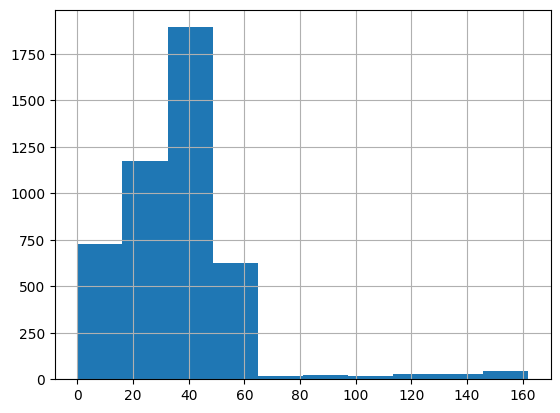

In [131]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты?). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной. 

Эта дата '2021-03-13' (определил ее выше)

Добавьте 5 своих примеров ниже. Опишите, как вы их искали. 

In [132]:
items[items.title.str.contains('007', na=False)]

,item_id,title
654,3963,Сплетница (2007)
9775,9031,007: Координаты «Скайфолл»
14037,7376,Преступление и наказание (2007)
15633,4385,007: СПЕКТР


007: СПЕКТР


<Axes: >

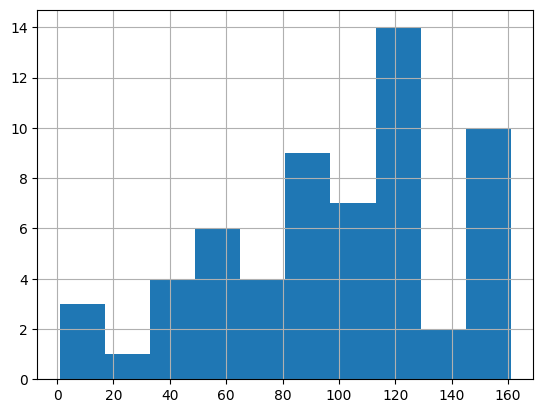

In [133]:
movie_1 = 4385

interactions_1 = df.loc[df.item_id==movie_1].copy()
name = items.loc[items.item_id==movie_1].title.values[0]
print(name)
interactions_1.last_watch_dt.hist()

Из графика видно, что со 120 по 150 день количество просмотров выросло. Посмотрим на какие даты приходится этот период.

In [134]:
from datetime import datetime, timedelta

date1 = datetime(2021, 3, 13)

new_date_1 = date1 + timedelta(days=120)
new_date_2 = date1 + timedelta(days=160)

print(new_date_1, new_date_2)

2021-07-11 00:00:00 2021-08-20 00:00:00


Данный период приходится на июль-август 2021 года. При этом в сентябре 2021 года состоялась мировая премьера новой части 007: Не время умирать. Таким образом, рост популярности 007: Спектр может быть связан с премьерой нового фильма, перед которой пользователи решили пересмотреть старые.  

Проверим, выполняется ли эта логика для другого фильма про Джеймса Бонда 007: Координаты Скайфолл (вышел в 2012)

007: Координаты «Скайфолл»


<Axes: >

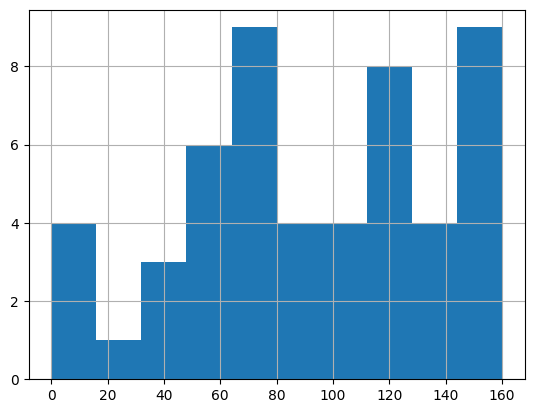

In [135]:
movie_2 = 9031

interactions_2 = df.loc[df.item_id==movie_2].copy()
name = items.loc[items.item_id==movie_2].title.values[0]
print(name)
interactions_2.last_watch_dt.hist()

В целом также видно, что у фильма Кординаты "Скайфолл" растут просмотры со 110 по 160 день, что также подтверждает гипотезу (накануне премьеры зрители пересматривают предыдущие серии фильмов)

In [154]:
items[items.title.str.contains('Болейн', na=False)]

,item_id,title
9023,3190,Ещё одна из рода Болейн
12201,3403,Анна Болейн


Ещё одна из рода Болейн


<Axes: >

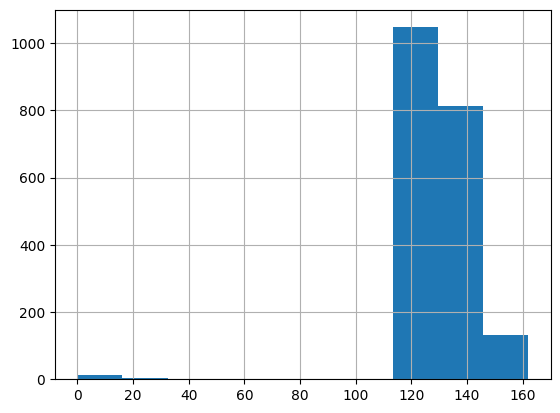

In [159]:
movie_3 = 3190

interactions_3 = df.loc[df.item_id==movie_3].copy()
name = items.loc[items.item_id==movie_3].title.values[0]
print(name)
interactions_3.last_watch_dt.hist()

In [157]:
new_date_4 = date1 + timedelta(days=115)
new_date_5 = date1 + timedelta(days=140)

print(new_date_4, new_date_5)

2021-07-06 00:00:00 2021-07-31 00:00:00


1 июня 2021 года стартовал показ сериала про жену короля Генриха 8го "Анна Болейн". Мы видим, для фильма 2008 года с похожим названием "Еще одназ рода Болейн" в июне-июле происходит всплеск просморов. Вероятно, зрители просто перепутали старый фильм с новым сериалом, когда искали премьеру.

In [160]:
items[items.title.str.contains('День города', na=False)]

,item_id,title
6425,11237,День города


День города


<Axes: >

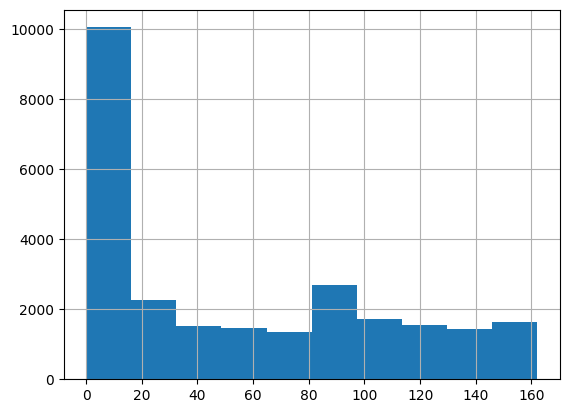

In [161]:
movie_4 = 11237

interactions_4 = df.loc[df.item_id==movie_4].copy()
name = items.loc[items.item_id==movie_4].title.values[0]
print(name)
interactions_4.last_watch_dt.hist()

В конце января 2021 вышел в прокат фильм "День города". Из графика видно, что вероятно в марте он стал появляться в онлайн кинотеатрах и на март пришелся пик его просмотров.

In [162]:
items[items.title.str.contains('Легенда', na=False)]

,item_id,title
19,15261,Спящая красавица. Легенда двух королевств: Лед...
152,10994,Легенда о коловрате
1995,13633,Враг государства №1: Легенда
2441,11527,Легенда Зорро
3183,1003,Лего. Легенда Ниндзяго
3912,13649,Легенда о великом мастере дзюдо 2
4292,3088,ЛЕГО. Мир юрского периода: Легенда острова Нублар
4532,5724,[4К] Легендарные крушения Корсики
5581,6025,Легенда о Тиле. Фильм первый – Пепел Клааса
5745,1241,Легенда андеграунда


Легенда № 17


<Axes: >

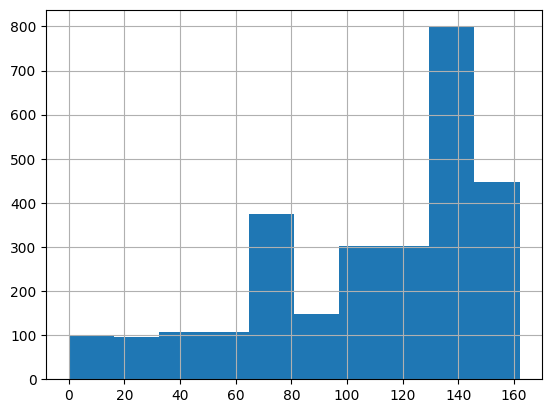

In [163]:
movie_5 = 760

interactions_5 = df.loc[df.item_id==movie_5].copy()
name = items.loc[items.item_id==movie_5].title.values[0]
print(name)
interactions_5.last_watch_dt.hist()

In [166]:
new_date_9 = date1 + timedelta(days=60)
new_date_10 = date1 + timedelta(days=80)

print(new_date_9, new_date_10)

2021-05-12 00:00:00 2021-06-01 00:00:00


Мы видим что на май 2021 пришелся рост просмотра фильма Легенда №17. Май - достаточно хоккейный месяц. В мае проходит Чемпионат мира по хоккею с шайбой, финал Кубка Гагарина, плейофф Кубка Стенли. На фоне этого зрители могли чаще просматривать кино про хоккей.

In [167]:
items[items.title.str.contains('Дуров', na=False)]

,item_id,title
3875,6809,Дуров
4891,14643,Дедушка Дуров


Дуров


<Axes: >

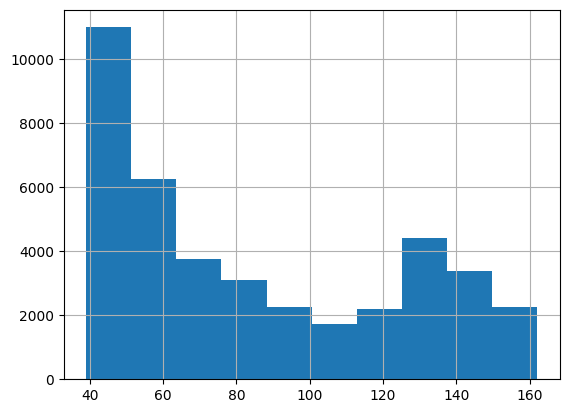

In [168]:
movie_6 = 6809

interactions_6 = df.loc[df.item_id==movie_6].copy()
name = items.loc[items.item_id==movie_6].title.values[0]
print(name)
interactions_6.last_watch_dt.hist()

В конце апреле 2021 состялась премьера фильма Дуров, про основателя ВК и ТГ Павла Дурова. Пик популярности как раз приходится примерно на эти даты.

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках. 

In [169]:
df = pd.read_csv('interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [174]:
def filter_column(df, min_freq):
    """
    Filter dataframe, excluding least active users and least popular items.
    Return a copy of the dataframe with at least min_freq entries
    in both users and items
    """
    user_counts = df['user_id'].value_counts()
    item_counts = df['item_id'].value_counts()
    
    filtered_df = df[(df['user_id'].isin(user_counts[user_counts >= min_freq].index)) &
                     (df['item_id'].isin(item_counts[item_counts >= min_freq].index))]
    
    return filtered_df

def filter_dataframe(df, cols, min_freq=5):
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Return a copy
    of the dataframe
    """
    if cols is None or len(cols) == 0:
        cols = ['user_id', 'item_id']

    changed = True

    while changed:
        prev_df = df.copy()
        filtered_df_temp = filter_column(df.copy(), min_freq)
        changed = not (prev_df.equals(filtered_df_temp))
        df=filtered_df_temp
        
        if not changed or len(prev_df) == len(filtered_df_temp): 
            break 

    return filtered_df_temp

filtered_train = filter_dataframe(df, ['user_id', 'item_id'])

In [ ]:
def df_encode(df):
    item2id = {k:v for v, k in enumerate(df['item_id'].unique())}
    user2id = {k:v for v, k in enumerate(df['user_id'].unique())}
    
    id2item = {v: k for k,v in item2id.items()}  
    id2user = {v: k for k,v in user2id.items()}

    df['encoded_user'] = df.user_id.apply(lambda x: user2id[x])
    df['encoded_item'] = df.item_id.apply(lambda x: item2id[x])
    
    return df

filtered_train = df_encode(filtered_train)
filtered_train.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,encoded_user,encoded_item
4498508,371570,4151,2021-06-01,26399,100.0,49103,147
2197579,966075,1112,2021-06-20,294,6.0,6429,436
2979185,888362,10440,2021-07-19,16,0.0,150569,32
678481,626691,9159,2021-08-17,1635,23.0,217230,488
3105343,687957,14264,2021-08-01,474,5.0,250288,160


In [176]:
user2id = np.array(filtered_train.user_id)
item2id = np.array(filtered_train.item_id)

In [177]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<4278492x4278492 sparse matrix of type '<class 'numpy.float64'>'
	with 4278492 stored elements in COOrdinate format>

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра. 

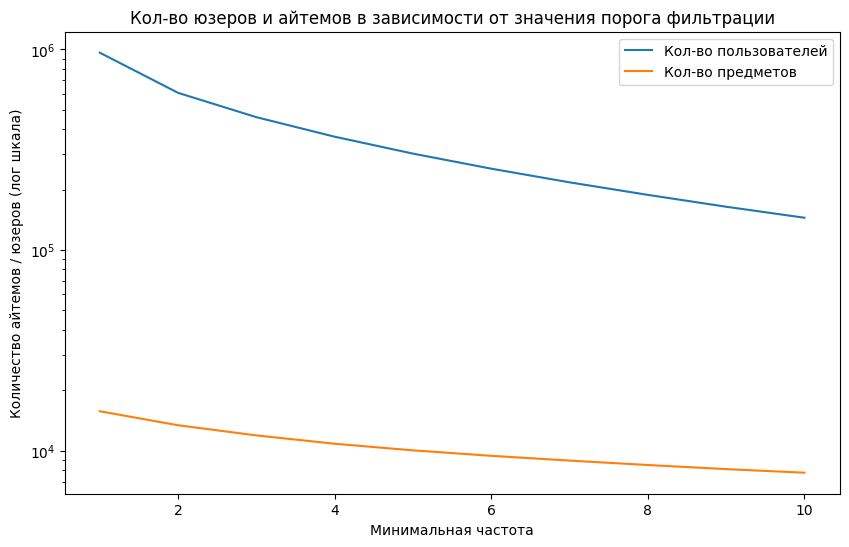

In [186]:
def plot_dependency(df):
    
    min_freq_values = range(1, 11)
    
    users_count_list = []
    items_count_list = []

    for min_freq in min_freq_values:
        filtered_df_temp = filter_dataframe(df.copy(), ['user_id', 'item_id'], min_freq)
        
        if not filtered_df_temp.empty:
            users_count_list.append(filtered_df_temp['user_id'].nunique())
            items_count_list.append(filtered_df_temp['item_id'].nunique())
        else:
            users_count_list.append(0)
            items_count_list.append(0)

    plt.figure(figsize=(10, 6))

    plt.plot(min_freq_values, users_count_list, label='Кол-во пользователей')
    plt.plot(min_freq_values, items_count_list, label='Кол-во предметов')

    plt.xlabel('Минимальная частота')
    plt.ylabel('Количество айтемов / юзеров (лог шкала)')
    plt.yscale('log')
    plt.title('Кол-во юзеров и айтемов в зависимости от значения порога фильтрации')
    
    if len(users_count_list) > 0 and len(items_count_list) > 0:
        plt.legend()

    plt.show()


plot_dependency(df)

На графике мы видим следующую картину: при увеличении порога снижается как количество пользователей, так и количество айтемов. В целом, это логично что увеличивая порог мы отбрасываем и айтемы и пользователей, оставляя только тех, кто имеет наиболее высокую частоту взаимодействия.

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k. 

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [ ]:
%%time

# Обучаем конечную модель
# Мы взяли реализацию из RecBole
#
def fit_ease(X, reg_weight=1000):

    # your code here

    return B

w = fit_ease(matrix)

CPU times: user 5.12 s, sys: 555 ms, total: 5.67 s
Wall time: 3.24 s


Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [ ]:
def get_preds(x, item2id, id2item):

    #your code here

    return decoded


joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,temp,inter_len,ease_preds
0,179,"[(14, 75), (13865, 95), (10440, 95), (9728, 97)]","[(15297, 157)]","[7409, 3306, 14709]","[10440, 9728, 15297, 13865, 3734, 4151, 2657, ...","[10440, 9728, 15297, 13865, 3734, 4151, 2657, ...",1,"[15297, 9728, 10440, 13865, 3734, 9996, 2657, ..."
1,304,"[(11985, 71), (2301, 71), (175, 75), (4457, 99...","[(6054, 161), (4073, 161)]","[7409, 3306, 14709]","[10440, 9728, 15297, 13865, 3734, 4151, 2657, ...","[10440, 9728, 15297, 13865, 3734, 4151, 2657, ...",2,"[13865, 10440, 7829, 9728, 3734, 7793, 12995, ..."
2,415,"[(3734, 105), (7571, 108), (8442, 110), (4457,...","[(12527, 154), (5330, 162), (16152, 162), (103...","[7409, 3306, 14709]","[10440, 9728, 15297, 13865, 3734, 4151, 2657, ...","[10440, 9728, 15297, 13865, 3734, 4151, 2657, ...",4,"[9728, 10440, 3734, 4880, 15297, 13865, 4151, ..."
3,425,"[(10440, 142)]","[(12360, 156)]","[7409, 3306, 14709]","[10440, 9728, 15297, 13865, 3734, 4151, 2657, ...","[10440, 9728, 15297, 13865, 3734, 4151, 2657, ...",1,"[15297, 13865, 9728, 2657, 4151, 9996, 142, 12..."
4,514,"[(5807, 113), (13865, 127)]","[(7728, 156), (1453, 158)]","[7409, 3306, 14709]","[10440, 9728, 15297, 13865, 3734, 4151, 2657, ...","[10440, 9728, 15297, 13865, 3734, 4151, 2657, ...",2,"[9728, 10440, 3734, 15297, 12995, 8636, 4495, ..."


In [ ]:
# your code here

Сделайте выводы — какой алгоритм работает лучше?

**Ответ:**

**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации. 

In [ ]:
#your code here

Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим? 


**Ответ:**

8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

**Ответ:**

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы. 

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

**Ответ:**

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций. 

In [ ]:
# your code here

Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:**